# Calculate Gain and Readout Noise

In [1]:
from astropy.io import fits
import numpy as np
import pathlib

In [16]:
# paths
path1 = pathlib.Path('data/20250515/cal')
path2 = pathlib.Path('data/20250602/cal')
flats1 = sorted(path1.glob('domeflat_g*.fit*'))
flats2 = sorted(path2.glob('domeflat_g*.fit*'))
biases1 = sorted(path1.glob('Bias*.fit*'))
biases2 = sorted(path2.glob('Bias*.fit*'))

In [17]:
# 2025/5/15
# load data
flat1 = fits.getdata(flats1[0]).astype('f4')
flat2 = fits.getdata(flats1[1]).astype('f4')
bias1 = fits.getdata(biases1[0]).astype('f4')
bias2 = fits.getdata(biases1[1]).astype('f4')
# trim (1024x1024) -> (824x824)
flat1 = flat1[100:-100,100:-100]
flat2 = flat2[100:-100,100:-100]
bias1 = bias1[100:-100, 100:-100]
bias2 = bias2[100:-100, 100:-100]

# GAIN 
# variance
flatDiff = flat2 - flat1
flatDiffVar = np.var(flatDiff)
# avg signal of two flats
meanSig = 0.5 * np.mean(flat1 + flat2)
# gain
gain = 2 * meanSig / flatDiffVar # in units of e-/ADU

# RoN
# variance
biasDiff = bias2 - bias1
biasDiffVar = np.var(biasDiff)
# readout noiiiiseeee
readout_noise = np.sqrt(biasDiffVar/2) # ron in adu
readout_noise *= gain # convert to e-

In [18]:
print(f'CCD data for 5/15 obs\nGain : {gain}\nReadout Noise : {readout_noise}')

CCD data for 5/15 obs
Gain : 1.4128618793879324
Readout Noise : 16.44310575649989


In [20]:
# 2025/6/2
# load data
flat1 = fits.getdata(flats2[0]).astype('f4')
flat2 = fits.getdata(flats2[1]).astype('f4')
bias1 = fits.getdata(biases2[0]).astype('f4')
bias2 = fits.getdata(biases2[1]).astype('f4')
# trim (1024x1024) -> (824x824)
flat1 = flat1[100:-100,100:-100]
flat2 = flat2[100:-100,100:-100]
bias1 = bias1[100:-100, 100:-100]
bias2 = bias2[100:-100, 100:-100]

# GAIN 
# variance
flatDiff = flat2 - flat1
flatDiffVar = np.var(flatDiff)
# avg signal of two flats
meanSig = 0.5 * np.mean(flat1 + flat2)
# gain
gain = 2 * meanSig / flatDiffVar # in units of e-/ADU

# RoN
# variance
biasDiff = bias2 - bias1
biasDiffVar = np.var(biasDiff)
# readout noiiiiseeee
readout_noise = np.sqrt(biasDiffVar/2) # ron in adu
readout_noise *= gain # convert to e-

print(f'CCD data for 6/2 obs\nGain : {gain}\nReadout Noise : {readout_noise}')

CCD data for 6/2 obs
Gain : 1.4088765817882778
Readout Noise : 18.213808163976502


# Visualizing Lines of Sight of the Observations
using some tools from a module i made to visualize NEO (..has been frankenstein'd for this project)

Vesta is not an NEO -- it's in the main asteroid belt, but NV can plot any solar system object's orbit

In [22]:
from astropy.time import Time
from astropy.coordinates import Angle, SkyCoord, EarthLocation, get_body_barycentric
import astropy.units as u
import NEOvisualizer as nv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
from importlib import reload
from ipywidgets import interact, fixed, FloatSlider

In [23]:
%matplotlib widget

In [24]:
# Vesta orbit params from JPL SBDB
d = {'a': 2.361397458473309,
     'e': 0.09010712502848492,
     'i': 7.143943095399415,
     'om': 103.7029211881615,
     'w': 151.5834106572105,
     'ma': 332.4506644374986,
     'n': 0.2716129276226057,
     'epoch': 2460800.5}
vestaOrb = pd.Series(data=d, index=['a','e','i','om','w','ma','n','epoch'])
vesta = nv.NEOvisualizer(vestaOrb)

In [25]:
# Test: one instance of observation
vesta1s_path = pathlib.Path('data/20250602/sci_reduced/vesta_1s_exp')
test = sorted(vesta1s_path.glob('reduced*.fits'))
# fits file
hdul = fits.open(test[0])
header = hdul[0].header
# ra and dec, convert to decimals
ra = Angle(header['RA'], unit=u.hourangle).degree *u.deg 
dec = Angle(header['DEC'], unit=u.deg).degree *u.deg
# some obs data
obs_time = Time(header['DATE-OBS'], format='isot', scale='utc')
apo= EarthLocation.of_site('Apache Point Observatory')

# get xyz coord in J2000 ecliptic from ra/dec, obs info
targLoc = SkyCoord(ra=ra,dec=dec,frame='icrs', obstime=obs_time, location=apo)
targEcliptic = targLoc.transform_to('barycentrictrueecliptic') # convert to j2000 ecliptic
targEcliptic.representation_type ='cartesian' # make sure to have it in xyz
eclipUnitVec = targEcliptic.cartesian.xyz # since w dont have a scale factor, extract direction
# get earth loc
earth_pos = get_body_barycentric('earth', obs_time)
earth_eclipt = SkyCoord(earth_pos).transform_to('barycentrictrueecliptic')
earth_xyz = earth_eclipt.cartesian.xyz.to(u.AU)
# Assume some distance (no need for accuracy, just need a line of sight)
distance = 2.3 * u.AU
target_xyz = earth_xyz + distance * eclipUnitVec # direction from earth, scaled by arbitrary distance

interactive(children=(FloatSlider(value=2.5, description='radius', max=10.0, min=0.1), Output()), _dom_classes…

<function __main__.plot(ax, radius)>

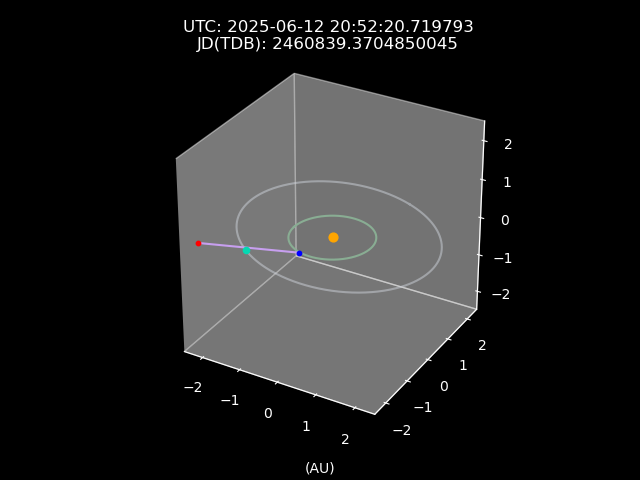

In [26]:
# plot time!
plt.style.use('dark_background')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}) # new figure

# set figure axis scales and aspects -- manually adjust for each object's semimajor axis
radius = 5.0
ax.set_xlim3d(-radius/2,radius/2)
ax.set_ylim3d(-radius/2,radius/2)
ax.set_zlim3d(-radius/2,radius/2)
ax.set_box_aspect(aspect=(1, 1, 1))
ax.grid(visible=False)
#ax.set_axis_off()


today = Time.now()
utc = today.utc
JDTDB = today.tdb.jd
# Title and label
fig.text(0.5,0.01,s='(AU)',ha='center',va='bottom')
ax.set_title("UTC: {}\nJD(TDB): {}".format(utc, JDTDB))


# plot the Sun
ax.scatter(0,0,0, c='orange', s=40)

# plot the Earth
nv.plotEarth(ax, time=JDTDB)

#plot vesta
vesta.plotOrbit(ax, False)
vesta.plotNEO(ax, colorStr='xkcd:aquamarine')

# TEST plot target_xyz
tx = target_xyz[0].value
ty = target_xyz[1].value
tz = target_xyz[2].value
# TEST plot earth pos at obs
ex = earth_xyz[0].value
ey = earth_xyz[1].value
ez = earth_xyz[2].value

ax.scatter(tx, ty, tz, c='red', s=10) # vesta
ax.scatter(ex, ey, ez, c='blue', s=10) # earth
# line of sight
lx = [tx, ex]
ly = [ty, ey]
lz = [tz, ez]
ax.plot(lx,ly,lz, color='xkcd:lavender', linestyle='-')

# Interactive    
def plot(ax, radius):
    ax.set_xlim3d(-radius,radius)
    ax.set_ylim3d(-radius,radius)
    ax.set_zlim3d(-radius,radius)

interact(plot, ax=fixed(ax), radius = FloatSlider(value=2.5, min=0.1, max=10.0, step=0.1))

Observation was about 9-10 days ago - vesta (cyan) is slightly out of the way, which seems right to me.
Okay, time to plot this for all of our observation data!

In [31]:
# Lets get our science fits paths
path_may = pathlib.Path('data/20250515/sci_reduced/Vesta')
path_june = pathlib.Path('data/20250515/sci_reduced')
path_1s = path_june / 'vesta_1s_exp'
path_5s = path_june / 'vesta_5s_exp'

files_may = sorted(path_may.glob('*'))
files_1s = sorted(path_1s.glob('*'))
files_5s = sorted(path_5s.glob('*'))

In [37]:
vesta_pos=[]
earth_pos=[]
apo = EarthLocation.of_site('Apache Point Observatory')
for file in files_may:
    hdul = fits.open(file)
    hdr = hdul[0].header
    obstime = Time(hdr['DATE-OBS'], format='isot', scale='utc')
    ra = Angle(hdr['RA'], unit=u.hourangle).degree * u.deg
    dec = Angle(hdr['DEC'], unit=u.deg).degree * u.deg
    targetEclip = SkyCoord(ra=ra,dec=dec,frame='icrs', obstime=obstime, location=apo).transform_to('barycentrictrueecliptic')
    targetEclip.representation_type = 'cartesian'
    unitVec = targetEclip.cartesian.xyz
    earthLoc = get_body_barycentric('earth', obstime)
    earthEclip = SkyCoord(earthLoc).transform_to('barycentrictrueecliptic')
    earth_xyz = earthEclip.cartesian.xyz.to(u.AU)
    dist = 2.3 * u.AU
    target_xyz = earth_xyz + dist * unitVec
    vesta_pos.append(target_xyz)
    earth_pos.append(earth_xyz)

interactive(children=(FloatSlider(value=2.5, description='radius', max=10.0, min=0.1), Output()), _dom_classes…

<function __main__.plot(ax, radius)>

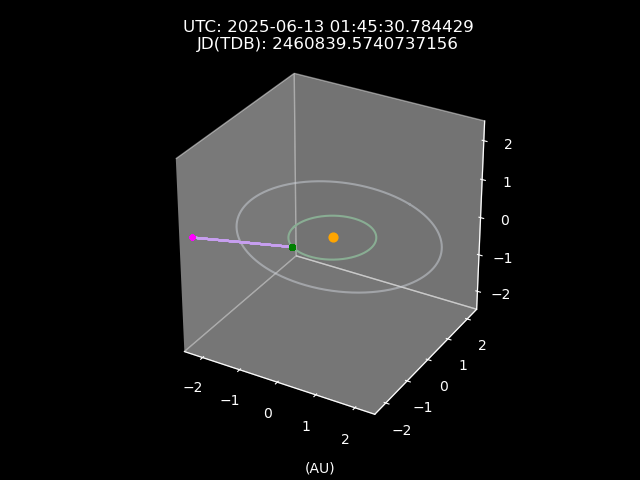

In [38]:
# plot time!
plt.close('all') # close other open plots in the background
plt.style.use('dark_background')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}) # new figure

# set figure axis scales and aspects
radius = 5.0
ax.set_xlim3d(-radius/2,radius/2)
ax.set_ylim3d(-radius/2,radius/2)
ax.set_zlim3d(-radius/2,radius/2)
ax.set_box_aspect(aspect=(1, 1, 1))
ax.grid(visible=False)
#ax.set_axis_off()


today = Time.now()
utc = today.utc
JDTDB = today.tdb.jd
# Title and label
fig.text(0.5,0.01,s='(AU)',ha='center',va='bottom')
ax.set_title("UTC: {}\nJD(TDB): {}".format(utc, JDTDB))


# plot the Sun
ax.scatter(0,0,0, c='orange', s=40)

# plot the Earth
nv.plotEarth(ax, time=JDTDB)

#plot vesta
vesta.plotOrbit(ax, False)
#vesta.plotNEO(ax, colorStr='xkcd:aquamarine')

# TEST
for vpos, epos in zip(vesta_pos, earth_pos):
    vx = vpos[0].value
    vy = vpos[1].value
    vz = vpos[2].value
    ex = epos[0].value
    ey = epos[1].value
    ez = epos[2].value
    lx = [vx,ex]
    ly = [vy,ey]
    lz = [vz,ez]
    ax.plot(lx,ly,lz, color='xkcd:lavender', linestyle='-')
    ax.scatter(vx,vy,vz, c='magenta', s=10)
    ax.scatter(ex,ey,ez, c='green', s=15)


# Interactive    
def plot(ax, radius):
    ax.set_xlim3d(-radius,radius)
    ax.set_ylim3d(-radius,radius)
    ax.set_zlim3d(-radius,radius)

interact(plot, ax=fixed(ax), radius = FloatSlider(value=2.5, min=0.1, max=10.0, step=0.1))

Well... our observations were not too far apart time wise, that we do not notice any difference than just 1 line.

We shall still try to get all other data to show up

In [39]:
vesta_pos=[]
earth_pos=[]
apo = EarthLocation.of_site('Apache Point Observatory')
for file in files_may:
    hdul = fits.open(file)
    hdr = hdul[0].header
    obstime = Time(hdr['DATE-OBS'], format='isot', scale='utc')
    ra = Angle(hdr['RA'], unit=u.hourangle).degree * u.deg
    dec = Angle(hdr['DEC'], unit=u.deg).degree * u.deg
    targetEclip = SkyCoord(ra=ra,dec=dec,frame='icrs', obstime=obstime, location=apo).transform_to('barycentrictrueecliptic')
    targetEclip.representation_type = 'cartesian'
    unitVec = targetEclip.cartesian.xyz
    earthLoc = get_body_barycentric('earth', obstime)
    earthEclip = SkyCoord(earthLoc).transform_to('barycentrictrueecliptic')
    earth_xyz = earthEclip.cartesian.xyz.to(u.AU)
    dist = 2.3 * u.AU
    target_xyz = earth_xyz + dist * unitVec
    vesta_pos.append(target_xyz)
    earth_pos.append(earth_xyz)
for file in files_1s:
    hdul = fits.open(file)
    hdr = hdul[0].header
    obstime = Time(hdr['DATE-OBS'], format='isot', scale='utc')
    ra = Angle(hdr['RA'], unit=u.hourangle).degree * u.deg
    dec = Angle(hdr['DEC'], unit=u.deg).degree * u.deg
    targetEclip = SkyCoord(ra=ra,dec=dec,frame='icrs', obstime=obstime, location=apo).transform_to('barycentrictrueecliptic')
    targetEclip.representation_type = 'cartesian'
    unitVec = targetEclip.cartesian.xyz
    earthLoc = get_body_barycentric('earth', obstime)
    earthEclip = SkyCoord(earthLoc).transform_to('barycentrictrueecliptic')
    earth_xyz = earthEclip.cartesian.xyz.to(u.AU)
    dist = 2.3 * u.AU
    target_xyz = earth_xyz + dist * unitVec
    vesta_pos.append(target_xyz)
    earth_pos.append(earth_xyz)
for file in files_5s:
    hdul = fits.open(file)
    hdr = hdul[0].header
    obstime = Time(hdr['DATE-OBS'], format='isot', scale='utc')
    ra = Angle(hdr['RA'], unit=u.hourangle).degree * u.deg
    dec = Angle(hdr['DEC'], unit=u.deg).degree * u.deg
    targetEclip = SkyCoord(ra=ra,dec=dec,frame='icrs', obstime=obstime, location=apo).transform_to('barycentrictrueecliptic')
    targetEclip.representation_type = 'cartesian'
    unitVec = targetEclip.cartesian.xyz
    earthLoc = get_body_barycentric('earth', obstime)
    earthEclip = SkyCoord(earthLoc).transform_to('barycentrictrueecliptic')
    earth_xyz = earthEclip.cartesian.xyz.to(u.AU)
    dist = 2.3 * u.AU
    target_xyz = earth_xyz + dist * unitVec
    vesta_pos.append(target_xyz)
    earth_pos.append(earth_xyz)

interactive(children=(FloatSlider(value=2.5, description='radius', max=10.0, min=0.1), Output()), _dom_classes…

<function __main__.plot(ax, radius)>

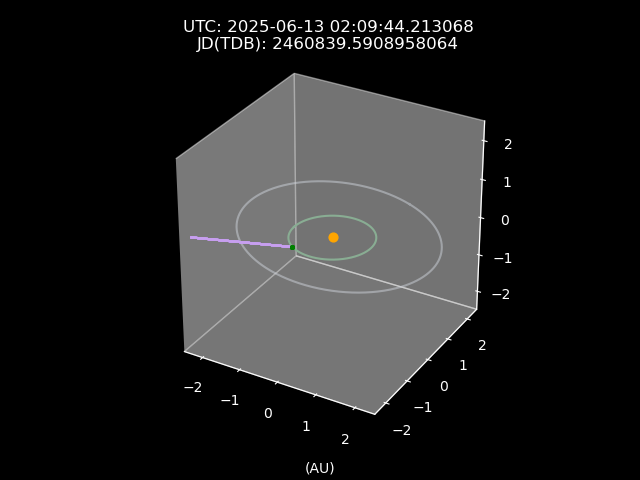

In [50]:
# plot time!
plt.close('all') # close other open plots in the background
plt.style.use('dark_background')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}) # new figure

# set figure axis scales and aspects 
radius = 5.0
ax.set_xlim3d(-radius/2,radius/2)
ax.set_ylim3d(-radius/2,radius/2)
ax.set_zlim3d(-radius/2,radius/2)
ax.set_box_aspect(aspect=(1, 1, 1))
ax.grid(visible=False)
#ax.set_axis_off()


today = Time.now()
utc = today.utc
JDTDB = today.tdb.jd
# Title and label
fig.text(0.5,0.01,s='(AU)',ha='center',va='bottom')
ax.set_title("UTC: {}\nJD(TDB): {}".format(utc, JDTDB))


# plot the Sun
ax.scatter(0,0,0, c='orange', s=40)

# plot the Earth
nv.plotEarth(ax, time=JDTDB)

#plot vesta
vesta.plotOrbit(ax, False)
#vesta.plotNEO(ax, colorStr='xkcd:aquamarine')

# TEST
for vpos, epos in zip(vesta_pos, earth_pos):
    vx = vpos[0].value
    vy = vpos[1].value
    vz = vpos[2].value
    ex = epos[0].value
    ey = epos[1].value
    ez = epos[2].value
    lx = [vx,ex]
    ly = [vy,ey]
    lz = [vz,ez]
    ax.plot(lx,ly,lz, color='xkcd:lavender', linestyle='-')
    #ax.scatter(vx,vy,vz, c='magenta', s=5)
    ax.scatter(ex,ey,ez, c='green', s=5)
    #print(lx,ly,lz)


# Interactive    
def plot(ax, radius):
    ax.set_xlim3d(-radius,radius)
    ax.set_ylim3d(-radius,radius)
    ax.set_zlim3d(-radius,radius)

interact(plot, ax=fixed(ax), radius = FloatSlider(value=2.5, min=0.1, max=10.0, step=0.1))

## The Problem
is that Vesta's orbital period is long (>3.6 earth year) and our two successful observations are less than 3 weeks apart.
The variation is not big enough to show on our plot.
# NO NO thats not true?!
### thats like 10% of this boi's orbit!!!! whats wrong????.......

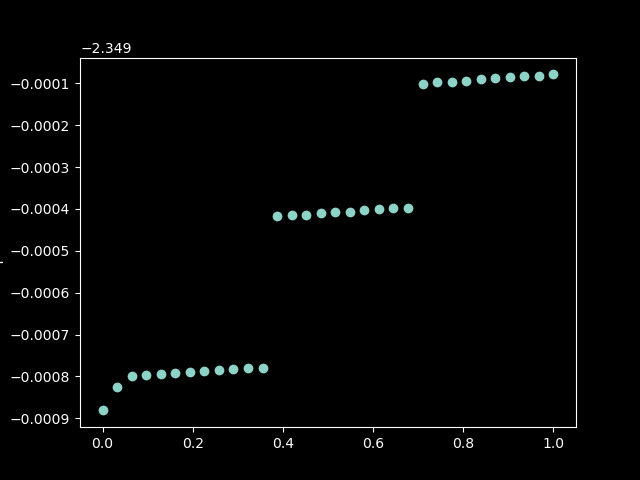

In [56]:
plt.close('all')
vx = [v[0].value for v in vesta_pos]
vy = [v[1].value for v in vesta_pos]
dummy = np.linspace(0,1,len(vx))
plt.scatter(dummy,vx)
plt.ylabel('x position')
plt.show()